<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/22_10kGNAD_deepset_farm_haystack_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying German News Articles with deepset's Farm/Haystack

NOTE: [deepset's Farm](https://github.com/deepset-ai/farm/) is now part of [deepset's Haystack](https://github.com/deepset-ai/haystack/). Still, the Farm documentation is helpful for classification implementation as haystack focuses on question answering.

## Objectives

1. Train a text classifier with transfer learning based on a pretrained German transformer model.
2. Simplify implementation by using [deepset's Farm](https://github.com/deepset-ai/FARM) library.

based on https://towardsdatascience.com/fine-tuning-bert-for-text-classification-with-farm-2880665065e2

## Prerequisites

In [1]:
checkpoint = "distilbert-base-german-cased"

# checkpoint = "deepset/gbert-base"

# checkpoint = "deepset/gelectra-base"

project_name = "10kgnad_huggingface__" + checkpoint.replace("/", "_")

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Nov 28 20:49:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install and Configure Packages

In [3]:
%%time
# ensure the right torch versions (https://pytorch.org/get-started/previous-versions/)
!pip install -q --upgrade torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 >/dev/null
!pip install -q --upgrade farm-haystack >/dev/null

# check installed version
!pip freeze | grep transformers
!pip freeze | grep farm
!pip freeze | grep torch
# transformers==4.6.1
# farm==0.8.0
# farm-haystack==0.10.0
# torch==1.7.1
# torchaudio==0.7.2
# torchsummary==1.5.1
# torchtext==0.8.1
# torchvision==0.8.2

sentence-transformers==2.1.0
transformers==4.6.1
farm==0.8.0
farm-haystack==0.10.0
torch==1.7.1
torchaudio==0.7.2
torchsummary==1.5.1
torchtext==0.11.0
torchvision==0.8.2
CPU times: user 72.9 ms, sys: 42.9 ms, total: 116 ms
Wall time: 9.91 s


In [4]:
import os
import logging
import pandas as pd
from pathlib import Path

## Fetch Data

Download [10k German News Articles Dataset](https://tblock.github.io/10kGNAD/)

In [5]:
%env DIR=data

!mkdir -p $DIR
!wget -nc https://github.com/tblock/10kGNAD/blob/master/train.csv?raw=true -nv -O $DIR/train.csv
!wget -nc https://github.com/tblock/10kGNAD/blob/master/test.csv?raw=true -nv -O $DIR/test.csv
!ls -lAh $DIR | cut -d " " -f 5-

env: DIR=data

2.7M Nov 28 19:17 test2.csv
2.7M Nov 28 19:17 test.csv
 24M Nov 28 19:17 train2.csv
 24M Nov 28 19:17 train.csv


## Import Data

In [6]:
data_dir = Path(os.getenv("DIR"))

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

In [7]:
def load_file(filepath: Path) -> pd.DataFrame:
    f = pd.read_csv(filepath, sep=";", quotechar="'", names=['labels', 'text'])
    return f

In [8]:
train_df = load_file(data_dir / 'train.csv')
train_df.to_csv(data_dir / 'train2.csv')
print(f"{train_df.shape[0]:,} articles")
display(train_df.head())

9,245 articles


,labels,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


In [9]:
test_df = load_file(data_dir / 'test.csv')
test_df.to_csv(data_dir / 'test2.csv')
print(f"{test_df.shape[0]:,} articles")
display(test_df.head())

1,028 articles


,labels,text
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,Neues Video von Designern macht im Netz die Ru...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


## Experiment Logging Setup

Using MLFlow. Go to [public-mlflow.deepset.ai](https://public-mlflow.deepset.ai/#/experiments/378/s?params=lm_name%2C%20batch_size%2C%20epochs%2C%20lr) to see results.

In [10]:
from farm.utils import MLFlowLogger

ml_logger = MLFlowLogger(tracking_uri="https://public-mlflow.deepset.ai/")
ml_logger.init_experiment(experiment_name="10kGNAD", run_name="10kGNAD")


 __          __  _                            _        
 \ \        / / | |                          | |       
  \ \  /\  / /__| | ___ ___  _ __ ___   ___  | |_ ___  
   \ \/  \/ / _ \ |/ __/ _ \| '_ ` _ \ / _ \ | __/ _ \ 
    \  /\  /  __/ | (_| (_) | | | | | |  __/ | || (_) |
     \/  \/ \___|_|\___\___/|_| |_| |_|\___|  \__\___/ 
  ______      _____  __  __  
 |  ____/\   |  __ \|  \/  |              _.-^-._    .--.
 | |__ /  \  | |__) | \  / |           .-'   _   '-. |__|
 |  __/ /\ \ |  _  /| |\/| |          /     |_|     \|  |
 | | / ____ \| | \ \| |  | |         /               \  |
 |_|/_/    \_\_|  \_\_|  |_|        /|     _____     |\ |
                                     |    |==|==|    |  |
|---||---|---|---|---|---|---|---|---|    |--|--|    |  |
|---||---|---|---|---|---|---|---|---|    |==|==|    |  |
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 


## Training Data Setup

In [11]:
from transformers import AutoTokenizer
from farm.modeling.tokenization import Tokenizer
from farm.data_handler.processor import TextClassificationProcessor
from farm.data_handler.data_silo import DataSilo

In [12]:
# need to load transformer tokenizer first - FARM cannot infer lower case setting (it seems)
do_lower_case = AutoTokenizer.from_pretrained(checkpoint).do_lower_case
tokenizer = Tokenizer.load(checkpoint, do_lower_case=do_lower_case)
tokenizer

11/28/2021 20:49:34 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'DistilBertTokenizer'


PreTrainedTokenizerFast(name_or_path='distilbert-base-german-cased', vocab_size=31102, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [13]:
label_list = list(train_df.labels.unique())

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from farm.evaluation.metrics import register_metrics

def compute_metrics(preds, labels):
    return {
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro'),
        "recall": recall_score(labels, preds, average='macro'),
    }

register_metrics('eval_metrics', compute_metrics)


processor = TextClassificationProcessor(tokenizer=tokenizer,
                                        max_seq_len=tokenizer.model_max_length,
                                        data_dir='data',
                                        train_filename="train2.csv",
                                        dev_filename=None,
                                        test_filename="test2.csv",
                                        quote_char='"',
                                        delimiter=",",
                                        label_column_name="labels",
                                        label_list=label_list,
                                        metric='eval_metrics'
                                        # multilabel=True,
                                        # dev_split=0.1 # this will extract 10% of the train set to create a dev set
                                        )

11/28/2021 20:49:36 - WARNING - farm.data_handler.processor -   Currently no support in Processor for returning problematic ids


In [14]:
batch_size = 32 # larger batch sizes might use too much computing power in Colab

# set log level to INFO to see very verbose output
logging.getLogger("farm.data_handler.data_silo").setLevel(logging.WARN)
logging.getLogger("farm.data_handler.processor").setLevel(logging.WARN)

data_silo = DataSilo(
    processor=processor,
    batch_size=batch_size)

Preprocessing Dataset data/test2.csv: 100%|██████████| 1028/1028 [00:01<00:00, 709.32 Dicts/s]


## Model Setup

In [15]:
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.language_model import LanguageModel
from farm.modeling.prediction_head import TextClassificationHead
from farm.modeling.optimization import initialize_optimizer
from farm.train import Trainer
from farm.utils import set_all_seeds, initialize_device_settings

set_all_seeds(seed=42)
device, n_gpu = initialize_device_settings(use_cuda=True)

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '
11/28/2021 20:49:51 - INFO - faiss.loader -   Loading faiss with AVX2 support.
11/28/2021 20:49:51 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
11/28/2021 20:49:51 - INFO - faiss.loader -   Loading faiss.
11/28/2021 20:49:51 - INFO - faiss.loader -   Successfully loaded faiss.
11/28/2021 20:49:51 - INFO - farm.modeling.prediction_head -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
11/28/2021 20:49:51 - INFO - farm.utils -   Using device: CUDA 
11/28/2021 20:49:51 - INFO - far

In [16]:
# loading the pretrained BERT base cased model
language_model = LanguageModel.load(checkpoint)

# prediction head for our model that is suited for classifying news article genres
prediction_head = TextClassificationHead(num_labels=len(label_list))

model = AdaptiveModel(
        language_model=language_model,
        prediction_heads=[prediction_head],
        embeds_dropout_prob=0.1,
        lm_output_types=["per_sequence"],
        device=device)

n_epochs = 1
lr_rate = 3e-5

model, optimizer, lr_schedule = initialize_optimizer(
        model=model,
        learning_rate=lr_rate,
        device=device,
        n_batches=len(data_silo.loaders["train"]),
        n_epochs=n_epochs)

11/28/2021 20:49:51 - INFO - farm.modeling.language_model -   
11/28/2021 20:49:51 - INFO - farm.modeling.language_model -   LOADING MODEL
11/28/2021 20:49:51 - INFO - farm.modeling.language_model -   =============
11/28/2021 20:49:51 - INFO - farm.modeling.language_model -   Could not find distilbert-base-german-cased locally.
11/28/2021 20:49:51 - INFO - farm.modeling.language_model -   Looking on Transformers Model Hub (in local cache and online)...
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are init

In [17]:
evaluate_every = 100

trainer = Trainer(
        model=model,
        optimizer=optimizer,
        data_silo=data_silo,
        epochs=n_epochs,
        n_gpu=n_gpu,
        lr_schedule=lr_schedule,
        evaluate_every=evaluate_every,
        device=device)

In [18]:
%%time
import logging

# set log level to INFO to see very verbose output
logging.getLogger("farm.train").setLevel(logging.WARN)
logging.getLogger("farm.eval").setLevel(logging.WARN)

model = trainer.train()

Evaluating: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


CPU times: user 3min 50s, sys: 468 ms, total: 3min 51s
Wall time: 4min 14s


## Model Evaluation

In [19]:
from farm.eval import Evaluator

evaluator = Evaluator(
    data_loader=data_silo.get_data_loader("test"),
    tasks=data_silo.processor.tasks,
    device=device
)

In [20]:
results = evaluator.eval(model)

print("\n", results[0]['report'])

for metric in ["loss", "acc", "f1", "precision", "recall"]:
    print(f"{metric}: {results[0][metric]:.4}")

Evaluating: 100%|██████████| 33/33 [00:08<00:00,  3.83it/s]


                precision    recall  f1-score   support

        Sport     0.9835    0.9917    0.9876       120
       Kultur     0.8727    0.8889    0.8807        54
          Web     0.9176    0.9286    0.9231       168
   Wirtschaft     0.8298    0.8298    0.8298       141
       Inland     0.7870    0.8333    0.8095       102
         Etat     0.9032    0.8358    0.8682        67
International     0.8849    0.8146    0.8483       151
     Panorama     0.8092    0.8333    0.8211       168
 Wissenschaft     0.8475    0.8772    0.8621        57

     accuracy                         0.8696      1028
    macro avg     0.8706    0.8704    0.8700      1028
 weighted avg     0.8706    0.8696    0.8697      1028

loss: 0.3839
acc: 0.8696
f1: 0.87
precision: 0.8706
recall: 0.8704


### Making Predictions

In [21]:
from farm.infer import Inferencer

logging.getLogger("farm.utils").setLevel(logging.WARN)
logging.getLogger("farm.infer").setLevel(logging.WARN)

infer = Inferencer(model, processor, "text_classification", gpu=True)
preds = infer.inference_from_file("data/test2.csv")

11/28/2021 20:54:24 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
Inferencing Samples: 100%|██████████| 26/26 [00:00<00:00, 27.20 Batches/s]


In [22]:
pred_labels = [p["label"] for pred in preds for p in pred["predictions"]]
test_labels = test_df.labels
labels = sorted(test_df.labels.unique())
# labels = test_df.labels.value_counts().index

### Confusion Matrix

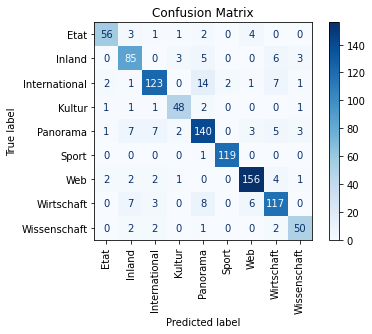

In [23]:
import sklearn.metrics as skm
import matplotlib.pyplot as plt

cm = skm.confusion_matrix(test_labels, pred_labels, labels=labels)
cmd = skm.ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix");